# WWA synthesis

- will need some modification to handle logged data, but this should be minor
  
Climate Explorer code: https://gitlab.com/KNMI-OSS/climexp/climexp_numerical/-/blob/master/src/synthesis.f90?ref_type%24=%24heads

- test that CX code (which works on 95% confidence intervals) translates correctly into the equations in the paper

In [3]:
prep_window <- function(rc = c(1,1), w = 4, h = 4, ...) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, ...) }

In [2]:
fnm <- "minisynth"

In [3]:
# load data
df_in = read.csv(paste0(fnm,"_in.txt"), comment.char = "#", header = F, sep = " ")
colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
obs_in = df_in[1:3,]
models_in = df_in[4:nrow(df_in),]

df_out <- read.fwf(paste0(fnm,"_out.txt"), comment.char = "#", header = F, widths = c(5,5,12,12,12,12,13,2,99))
df_out <- df_out[!is.na(df_out$V8),]
colnames(df_out) <- c("y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model")

obs_out <- df_out[df_out$group == 1,]
obs_synth <- df_out[df_out$group == 2,]
models_out <- df_out[df_out$group == 3,]
models_synth <- df_out[df_out$group == 4,]
overall_synth <- df_out[df_out$group == 5,]

nobs <- nrow(obs_in)
nmod <- nrow(models_in)

rep_unc <- 0.681
chi2_dof <- switch(fnm, "synthesis" = 11.85, "minisynth" = 44.28)         
mdl_unc <- switch(fnm, "synthesis" = 2.09, "minisynth" = 3.97)

## Mean & uncertainties of observations

Original Fortran code:
```
!   compute mean & uncertainties of observations
!
    if ( nobs > 0 ) then
!       natural variability: assume 100% correlated
        do j=1,3
            s1 = 0
            do i=1,nobs
                s1 = s1 + data(j,i)
            end do
            obs(j) = s1/nobs
        end do

!       representation error from scatter of mean
        if ( nobs > 1 .and. lweighted ) then
            s2 = 0
            do i=1,nobs
                s2 = s2 + (data(1,i)-obs(1))**2
            end do
            sig_obs = 2*sqrt(s2/(nobs-1)) ! added factor 2; sig_obs now 2*std to represent 2sigma
            obs(2) = obs(1) - sqrt( (obs(1)-obs(2))**2 + sig_obs**2 ) 
            obs(3) = obs(1) + sqrt( (obs(3)-obs(1))**2 + sig_obs**2 )
        else
            sig_obs = 0 ! cannot estimate it from one point...
        end if
        do i=1,nobs
            data(4,i) = data(1,i) - sqrt( (data(1,i)-data(2,i))**2 + sig_obs**2 )
            data(5,i) = data(1,i) + sqrt( (data(3,i)-data(1,i))**2 + sig_obs**2 )
        end do
        obs(4) = obs(2)
        obs(5) = obs(3)
        if ( lwrite ) print *,'found combined observational estimate ',obs
        if ( sig_obs > 0 ) then
            if ( llog ) then
                print '(a,g12.3)','# representation uncertainty (2&sigma;) factor ',exp(sig_obs)
            else if ( lperc ) then
                print '(a,g12.3,a)','# representation uncertainty (2&sigma;) ',100*(-1+exp(sig_obs)),'%'
            else
                print '(a,g12.3)','# representation uncertainty (2&sigma;) ',sig_obs
            end if
        end if
    end if
```

Suppose that the measure derived from the $i$th observation (out of a total of $n$ observational datasets) is normally distributed with mean $\mu_i$ and variance $\sigma_i^2$. Then we have
\begin{align}
\bar{\mu} &= \frac{1}{n}\sum_i \mu_i  && \text{Overall best estimate}
\\
\sigma^2_{nat} &= \frac{1}{n}\sum_i \sigma_i  && \text{Natural variability}
\\
\sigma^2_{obs} &= \frac{\sum_i \left(\mu_i - \bar{\mu}\right)^2}{n-1} && \text{Spread of best estimates - representation error}
\\
\sigma^2_{tot} &= \sigma^2_{nat} + \sigma_{obs}^2 && \text{Synthesised spread of all observations, including representation error}
\end{align}

&nbsp;

In practice, we work with confidence bounds ($\omega$, say) rather than with standard deviations, so that the $i$th dataset has best estimate $\mu_i$ and confidence bound $\omega_i$. Then we have
\begin{align}
\omega_{nat} &= \frac{1}{n}\sum_i \omega_i  && \text{Natural variability} 
\\
\omega_{tot} &= \bar{\mu} \pm \sqrt{\left(\omega_{nat} - \bar{\mu}\right)^2 + \sigma_{obs}^2} && \text{Total uncertainty, including representation error}
\\
\omega_i &= \mu_i \pm \sqrt{\left(\omega_{i} - \mu_i\right)^2 + \sigma_{obs}^2} && \text{Total uncertainty for observational dataset $i$}
\end{align}
&nbsp;

- **Confirm that these two are indeed equivalent**

In [48]:
# get mean of intervals to estimate natural variability component
obs = apply(obs_in[,c("est", "lower", "upper")], 2, mean)

# compute representation error from scatter of mean
nobs = nrow(obs_in)
s2 = sum((obs_in$est - obs[1])^2)
sig_obs = 2*sqrt(s2/(nobs-1))            # add 2 SDs to either side - representation uncertainty

# apply representation error to synthesis
obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + sig_obs**2 )
obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + sig_obs**2 )

# add representation error to observations
obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + sig_obs**2)
obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + sig_obs**2)

ERROR: Error in apply(obs_in[, c("est", "lower", "upper")], 2, mean): object 'obs_in' not found


## Mean & uncertainties of models

Original Fortran code:
```

!   compute mean & uncertainties of models
!
    call getsynmean(lweighted,data,n,nobs,sig_mod)
    if ( lwrite ) print *,'first guess of model mean is ',data(:,n+1)
    call getsynchi2(data,n,nobs,sig_mod,chi2)
    if ( lweighted ) then
        print '(a,g14.4)','# model chi2/dof = ',chi2/(n-nobs-1)
    end if
    if ( lweighted .and. .not.lnoave .and. chi2/(n-nobs-1) > 1 .and. sig_mod < 0 ) then
        ! compute sig_mod to make chi2/dof = 1
        syn_n = n ! copy to common as I am a F77 programmer and do not feel comfortable with f90 global variables
        syn_nobs = nobs
        syn_data(:,1:n) = data(:,1:n)
        s1 = 0
        s2 = data(3,n+1) - data(2,n+1)
        if ( syn_func(s1) <= 0 ) then
            write(0,*) 'synthesis: internal error: syn_func(0) should be > 0, not ',syn_func(s1)
            call exit(-1)
        end if
        s = syn_func(s2)
        do while ( s2 < 1e10 )
            s2 = 2*s2
            if ( s2 > 1e10 ) then
                write(0,*) 'synthesis: error: cannot find zero: ',s2
                call exit(-1)
            end if
            s = syn_func(s2)
            if ( s < 0 ) exit
        end do
        if ( lwrite ) print *,'bracketed sig_mod by ',s1,s2,', calling Brent'
        sig_mod = zbrent(syn_func,s1,s2,1e-4)
        !!!write(names(n)(len_trim(names(n))+1:),'(a,f4.2)') ' added ',sig_mod
        ! copy results back
        mod(1:3) = syn_data(1:3,n+1)
    else
        sig_mod = 0
        mod(1:3) = data(1:3,n+1)
    end if
    mod(4) = mod(2)
    mod(5) = mod(3)
    do i=nobs+1,n
        data(4,i) = data(1,i) - sqrt( (data(1,i)-data(2,i))**2 + sig_mod**2 )
        data(5,i) = data(1,i) + sqrt( (data(3,i)-data(1,i))**2 + sig_mod**2 )
    end do
    if ( lwrite ) print *,'found combined model estimate ',mod
```

Subroutines:
```
subroutine getsynmean(lweighted,data,n,nobs,sig_mod)
!
!   compute the mean of model data, either weighted with model error or unweighted
!   n is the number of input points, ..(n) denotes the average.
!
    implicit none
    logical,intent(in) :: lweighted
    integer,intent(in) :: n,nobs
    real,intent(in) :: sig_mod
    real,intent(inout) :: data(5,n+1)
    integer :: i,j
    real s1,ss2(3),w,w1
!
    s1 = 0
    ss2 = 0
    w1 = 0
    do i=nobs+1,n
        if ( lweighted ) then
            if ( abs(data(3,i) - data(2,i)) < 1e-6 ) then
                write(0,*) 'synthesis: error: upper and lower bound are equal: ',i,data(2,i),data(3,i)
                call exit(-1)
            end if
            if ( sig_mod > 0 ) then
                w = 1/((data(3,i) - data(2,i))**2 + (2*sig_mod)**2) ! factor 2 for sig_mod transforms from 2sigma to 4sigma
            else
                w = 1/(data(3,i) - data(2,i))**2
            end if
        else
            w = 1
        end if
        w1 = w1 + w
        s1 = s1 + w*data(1,i)
        do j=2,3
            ss2(j) = ss2(j) + (w*(data(1,i)-data(j,i)))**2
        end do
    end do
    s1 = s1/w1
    do j=2,3
        ss2(j) = sqrt(ss2(j))/w1
        if ( sig_mod > 0 ) then
            ss2(j) = sqrt(ss2(j)**2 + sig_mod**2)
        end if
    end do
    data(1,n+1) = s1
    data(2,n+1) = s1 - ss2(2)
    data(3,n+1) = s1 + ss2(3)
end subroutine getsynmean

subroutine getsynchi2(data,n,nobs,sig_mod,chi2)
!
!   compute chi2
!
    implicit none
    integer,intent(in) :: n,nobs
    real,intent(in) :: data(5,n+1)
    real,intent(out) :: sig_mod,chi2
    integer :: i
    real :: s1

    chi2 = 0
    s1 = data(1,n+1)
    do i=nobs+1,n
        if ( sig_mod > 0 ) then
            if ( data(1,i) > s1 ) then
                chi2 = chi2 + (data(1,i)-s1)**2/((data(1,i)-data(2,i))**2 + sig_mod**2)
            else
                chi2 = chi2 + (s1-data(1,i))**2/((data(3,i)-data(1,i))**2 + sig_mod**2)
            end if
        else
            if ( data(1,i) > s1 ) then
                chi2 = chi2 + ((data(1,i)-s1)/(data(1,i)-data(2,i)))**2
            else
                chi2 = chi2 + ((s1-data(1,i))/(data(3,i)-data(1,i)))**2
            end if
        end if
    end do
    chi2 = chi2*4 ! transformed to use 95%~2sigma CIs
end subroutine getsynchi2
```

In [5]:
getsynmean <- function(data, sig_mod = -1) {    
    
    # calculate weight for each model (based on width of confidence interval)
    if ( sig_mod > 0 ) {
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma
    } else {
        w = 1/(data$upper - data$lower)^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
                 
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + sig_mod^2) }
    
    return(s1 + (ss2 * c(0,-1,1)))
}

In [6]:
getsynchi2 <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, sig_mod)["est"]
    
    # determine adjustment to sigma, if any
    if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
    
    # compute chi2 based on model intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_adj^2)
        } else {
            (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_adj^2)
        }
    }))
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}

In [7]:
# get initial estimate of model mean & calculate chi^2
mmean_1 <- getsynmean(models_in, sig_mod = -1)
chi2 <- getsynchi2(models_in, sig_mod = -1)
mdof <- nrow(models_in)-1
print(chi2 / mdof)

# estimate sig_mod such that chi^2/dof = 1
# function to be minimized in order to constrain chi^2 to be close to 1
sigmod <- optim(-1, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
print(sigmod)

# weighted model mean
models <- getsynmean(models_in, sig_mod = sigmod)

# add representation error to observations
models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)

[1] 44.27627
[1] 3.972055


## Synthesis

```
!   compute synthesis: weighted average of obervations and models
!
    if ( nobs > 0 ) then
        if ( obs(2) >= obs(3) ) then
            write(0,*) 'synthesis: internal error: obs = ',obs
            call exit(-1)
        end if
        if ( mod(2) >= mod(3) ) then
            write(0,*) 'synthesis: internal error: mod = ',mod
            call exit(-1)
        end if
        if ( lweighted ) then
            ! weighted mean coloured
            w1 = 1/(obs(3)-obs(2))**2
            w2 = 1/(mod(3)-mod(2))**2
            syn(1) = (w1*obs(1) + w2*mod(1))/(w1+w2)
            syn(2) = syn(1) - sqrt( (w1*(obs(1)-obs(2)))**2 + (w2*(mod(1)-mod(2)))**2 )/(w1+w2)
            syn(3) = syn(1) + sqrt( (w1*(obs(3)-obs(1)))**2 + (w2*(mod(3)-mod(1)))**2 )/(w1+w2)
            ! unweighted mean of observations and models box
            s1 = (obs(1) + mod(1))/2
            syn(4) = s1 - sqrt( (obs(1)-obs(2))**2 + (mod(1)-mod(2))**2 )/2
            syn(5) = s1 + sqrt( (obs(3)-obs(1))**2 + (mod(3)-mod(1))**2 )/2
        else
            call getsynmean(lweighted,data,n,0,sig_mod)
            syn(1:3) = data(1:3,n+1)
            syn(4) = syn(2)
            syn(5) = syn(3)
        end if
        if ( lwrite ) print *,'found synthesised estimate ',syn
    end if
```


In [8]:
# weighted mean of models & obs (coloured bar)
w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
w_mod <- unname((models["upper"] - models["lower"])^{-2})

wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
synth <- setNames(c(wmean, 
                    wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                    wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)), c("est", "lower", "upper"))

# unweighted mean of obs and models
umean <- (obs["est"] +  models["est"]) / 2
synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

## Check results

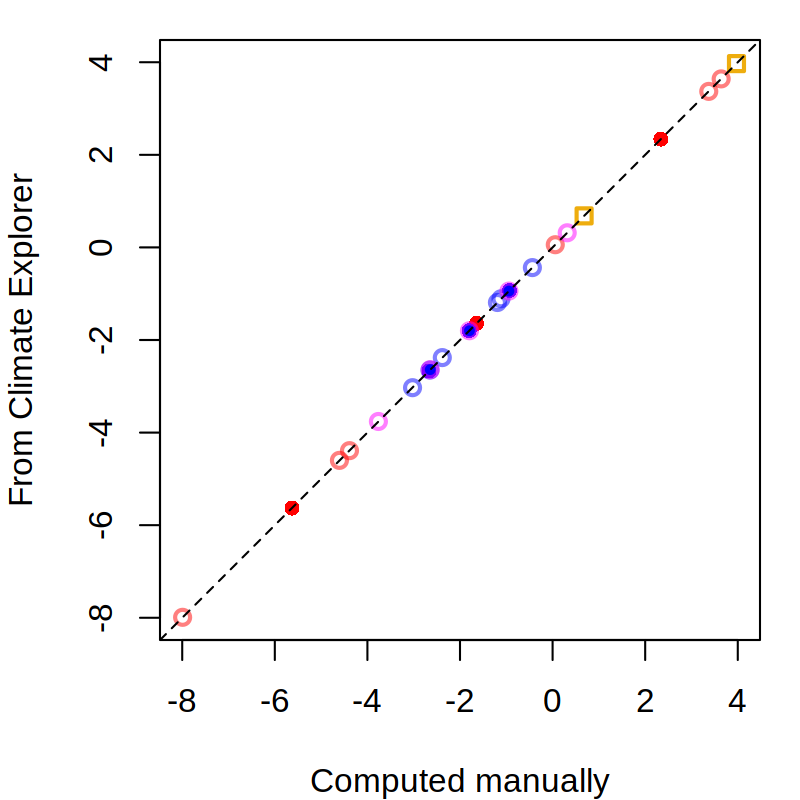

In [9]:
# check that my code does produce the same results as the Climate Explorer
prep_window(c(1,1)); par(mar = c(4,4,1,1))

xylims <- range(pretty(c(models, models_in$l_wb, models_in$u_wb, obs, obs_in$l_wb, obs_in$u_wb, synth)))

# uncertainty bounds for models
plot(models, unlist(models_synth[,c("est", "lower", "upper")]), col = "red", pch = 16, xlim = xylims, ylim = xylims,
     xlab = "Computed manually", ylab = "From Climate Explorer")
points(c(models_in$l_wb, models_in$u_wb), c(models_out$l_wb, models_out$u_wb), col = adjustcolor("red", alpha = 0.5), pch = 1, lwd = 2)

# uncertainty bounds for observations
points(obs, unlist(obs_synth[,c("est", "lower", "upper")]), col = "blue", pch = 16)
points(c(obs_in$l_wb, obs_in$u_wb), c(obs_out$l_wb, obs_out$u_wb), col = adjustcolor("blue", alpha = 0.5), pch = 1, lwd = 2)

# synthesis & uncertainty parameters
points(synth, unlist(overall_synth[c("est", "lower", "upper", "l_wb", "u_wb")]), col = adjustcolor("magenta", alpha = 0.5), pch = 1, lwd = 2)
points(c(sig_obs, chi2/mdof, sigmod), c(rep_unc, chi2_dof, mdl_unc), pch = 0, col = "darkgoldenrod2", lwd = 2)

abline(0,1, lty = 2)

## Synthesis plot

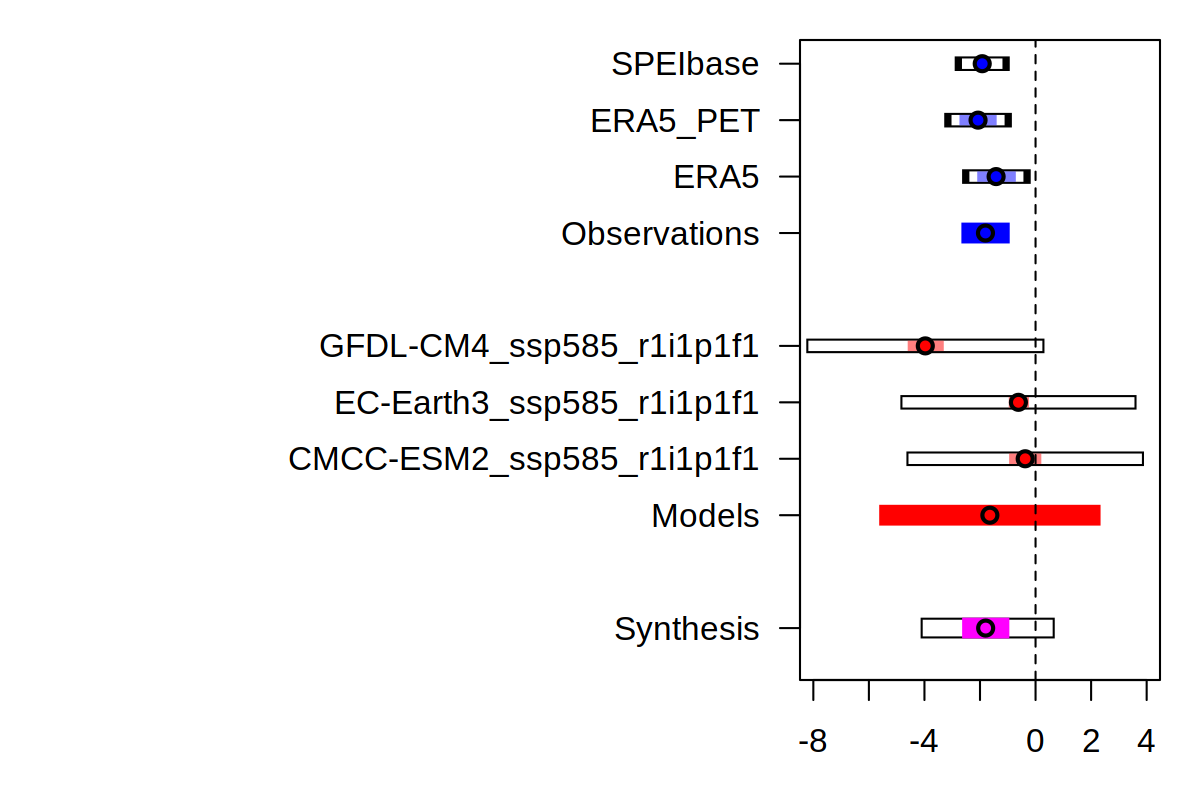

In [10]:
prep_window(c(1,1.5)); par(mfrow = c(1,1), mar = c(3,20,1,1))

# synthesis plot
# png("synth-example.png", height = 480*0.5, width = 480); par(cex.main = 1.4); {
    par(mfrow = c(1,1), mar = c(3,20,1,1))
    plot(0, type = "n", xlim = range(pretty(c(unlist(obs_in[,10:11]), unlist(models_in[,10:11])))), ylim = c(-0.5,nobs+nmod+4), yaxt = "n", ylab = "", xlab = "")
    
    segments(y0 = 1:nobs+nmod+4, x0 = obs_in$l_wb, x1 = obs_in$u_wb, lwd = 7, col = "black", lend = 2)
    segments(y0 = 1:nobs+nmod+4, x0 = obs_in$l_wb, x1 = obs_in$u_wb, lwd = 5, col = "white", lend = 1)
    segments(y0 = 1:nobs+nmod+4, x0 = obs_in$lower, x1 = obs_in$upper, lwd = 5, col = adjustcolor("blue", 0.5), lend = 1)
    points(obs_in$est, 1:nobs+nmod+4, pch = 21, bg = "blue", lwd = 2)
    
    segments(y0 = 1:nmod+2, x0 = models_in$l_wb, x1 = models_in$u_wb, lwd = 7, col = "black", lend = 2)
    segments(y0 = 1:nmod+2, x0 = models_in$l_wb, x1 = models_in$u_wb, lwd = 5, col = "white", lend = 2)
    segments(y0 =1:nmod+2, x0 = models_in$lower, x1 = models_in$upper, lwd = 5, col = adjustcolor("red", 0.5), lend = 1)
    points(models_in$est, 1:nmod+2, pch = 21, bg = "red", lwd = 2)
    
    lines(obs[2:3], rep(nmod+4,2), col = "blue", lwd = 10, lend = 1)
    points(obs["est"], nmod+4, pch = 21, bg = "blue", lwd = 2)
    
    lines(models[2:3], rep(2,2), col = "red", lwd = 10, lend = 1)
    points(models["est"], 2, pch = 21, bg = "red", lwd = 2)
    
    lines(synth[4:5], rep(0,2), lwd = 10, col = "black", lend = 2)
    lines(synth[4:5], rep(0,2), lwd = 8, col = "white", lend = 2)
    lines(synth[2:3], rep(0,2), col = "magenta", lwd = 10, lend = 1)
    points(synth["est"], 0, pch = 21, bg = "magenta", lwd = 2)
    
    axis(2, at = c(0,2,1:nmod+2,nmod+4,1:nobs+nmod+4),
        labels = c("Synthesis", "Models", models_in$model, "Observations", obs_in$model), las = 1)
    
    abline(v = 0, lty = 2)
# }; dev.off()

# Synthesis function

In [11]:
synth_fnm = "toy_in.txt"
df_in = read.csv(synth_fnm, comment.char = "#", header = F, sep = " ")
colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
obs_in = df_in[(df_in$m2 == "") & (!is.na(df_in$est)),]
models_in = df_in[df_in$m2 != "",]

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'toy_in.txt'”


In [53]:
getsynmean <- function(data, sig_mod = 0) {    
    
    # calculate weight for each model (based on width of confidence interval, so adding 2\sigma_{mrep} in quadrature)
    w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma, but this is then sqrted
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1

    # ss2 represents a confidence interval so think this should be (2*sig_mod)^2
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + sig_mod^2) }
    
    return(s1 + (ss2 * c(0,-1,1)))
}

getsynchi2 <- function(data, sig_mod = 0) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, sig_mod)["est"]

    # again, we're adding to bounds so should be adding (2sig_adj)^2 here - or is it handled below?
    # determine adjustment to sigma, if any
    if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
    
    # compute chi2 based on model intervals & sigma adjustment - this is a ratio of variances
    # actually I'm not sure if this shouldn't be the upper sum divided by the lower sum...
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_adj^2)
        } else {
            (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_adj^2)
        }
    }))

    # think this is supposed to give the same results as adding (2sig_adj)^2, but it won't
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}
                 
wwa_synthesis <- function(obs_in, models_in, take_logs = F) {

    # load data and split into obs & models
    # df_in = read.csv(synth_fnm, comment.char = "#", header = F, sep = " ")
    # colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
    # obs_in = df_in[df_in$m2 == "",]
    # models_in = df_in[df_in$m2 != "",]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if(take_logs) {
        obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
        models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
    }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get mean of intervals to estimate natural variability component
    
    # compute representation error from scatter of mean
    nobs = nrow(obs_in)
    obs <- apply(obs_in[,c("est", "lower", "upper")], 2, mean)
    if(nobs == 1) {
        sig_obs = 0
    } else {
        s2 = sum((obs_in$est - obs[1])^2)
        sig_obs = 2*sqrt(s2/(nobs-1))            # in the paper this is 2\sigma_{rep} - representation uncertainty
    }

    # we're working with confidence intervals here, so we extend them by adding (2\sigma_rep})^2 in quadrature
    # apply representation error to synthesis
    obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + sig_obs**2 )
    obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + sig_obs**2 )
    
    # add representation error to observations
    obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + sig_obs**2)
    obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + sig_obs**2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get initial estimate of model mean & calculate chi^2
    chi2 <- getsynchi2(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1

    if ( chi2/mdof > 1 ) {
        # estimate sig_mod such that chi^2/dof = 1
        # function to be minimized in order to constrain chi^2 to be close to 1
        sigmod <- optim(-1, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                        method = "Brent", lower = 0, upper = 5)$par
    } else {
        sigmod <- 0
    }
    
    
    # weighted model mean
    models <- getsynmean(models_in, sig_mod = sigmod)
    
    # add representation error to observations
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # weighted mean of models & obs (coloured bar)
    w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
    w_mod <- unname((models["upper"] - models["lower"])^{-2})

    wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    synth <- setNames(c(wmean, 
                        wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)), c("est", "lower", "upper"))

    
    # unweighted mean of obs and models
    umean <- (obs["est"] +  models["est"]) / 2
    synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
    synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    obs_in <- cbind(obs_in, "group" = "obs")
    obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
    models_in <- cbind(models_in, "group" = "models")
    models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
    synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

    res <- plyr::rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
    for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## REVERSE THE LOG-TRANSFORMATION, IF NECESSARY
    if (take_logs) {
        res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
        sig_obs = exp(sig_obs)
        sigmod = exp(sigmod)
    }
                               
    return(list(sig_rep = sig_obs, "chi2dof" = chi2 / mdof, df = res))
}
synth1 <- wwa_synthesis(obs_in, models_in)

In [13]:
synth1

group,model,est,lower,upper,l_wb,u_wb
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
obs,ERA5,50.000,10.00000,100.00000,10.0000,100.00000
obs_synth,Observations,50.000,10.00000,100.00000,NA,NA
models,MPI-ESM-LR_r1i1p1_REMO2015,60.000,30.00000,120.00000,30.0000,120.00000
models,MPI-ESM-LR_r1i1p1_REMO2016,80.000,40.00000,160.00000,40.0000,160.00000
models,MPI-ESM-LR_r1i1p1_REMO2017,100.000,50.00000,200.00000,50.0000,200.00000
model_synth,Models,73.342,51.70545,116.61511,NA,NA
synth,Synthesis,65.355,45.60879,98.56692,38.9326,94.73368


In [14]:
obs_in

,y0,y1,est,lower,upper,ci,model,m2,m3
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,1900,2020,50,10,100,95,ERA5,,


In [102]:
plot_synthesis <- function(synth, xlim, lwd = 7, vline = 0, xlab = "", main = "", add_space = T) {

    if (class(synth) == "list") synth <- synth$df
    if (missing(xlim)) xlim <- range(pretty(as.numeric(unlist(synth[,c("l_wb", "u_wb")]))))

    nobs <- sum(synth$group == "obs")
    nmod <- sum(synth$group == "models")

    if(add_space) {
        yy <- c(rev(0:nobs+nmod+4), rev(0:nmod+2), 0)
    } else {
        yy <- nrow(synth):1
    }
    
    
    plot(0, type = "n", xlim = xlim, ylim = range(yy) + c(-0.5,0.5),
         yaxt = "n", ylab = "", xlab = xlab, main = main)

    gcols = c("obs" = adjustcolor("blue", 0.5),
              "obs_synth" = "blue",
              "models" = adjustcolor("red", 0.5),
              "model_synth" = "red",
              "synth" = "magenta")[synth$group]
    
    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd, col = "black", lend = 2)
    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd-2, col = "white", lend = 2)
    segments(y0 = yy, x0 = synth$lower, x1 = synth$upper, lwd = lwd-2, col = gcols, lend = 1)
    points(synth$est, yy, pch = 21, bg = gcols, lwd = 2, cex = lwd/10)
    
    axis(2, at = yy, labels = synth$model, las = 1)    
    abline(v = vline, lty = 2)
}
synth1 <- wwa_synthesis("toy_in.txt")
par(mar = c(3,15,1,1))
plot_synthesis(synth1, lwd = 10)

ERROR: Error in obs_in[, c("est", "lower", "upper")]: incorrect number of dimensions


## Slightly modified synthesis plot

In [16]:
modsynmean <- function(data, sig_mod = 0) {    
    
    # calculate weight for each model (based on width of confidence interval)
    if ( sig_mod > 0 ) {
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma
    } else {
        w = 1/(data$upper - data$lower)^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
    ss2_mod <- sqrt(ss2^2 + sig_mod^2)[2:3]

    bounds <- s1 + c(ss2 * c(0,-1,1), ss2_mod*c(-1,1))
    bounds <- setNames(bounds, c("est", "lower", "upper", "l_wb", "u_wb"))
    return(bounds)
}

modsynchi2 <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- modsynmean(data, sig_mod = sig_mod)["est"]
    
    # determine adjustment to sigma, if any
    if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
    
    # compute chi2 based on model intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_adj^2)
        } else {
            (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_adj^2)
        }
    }))
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}
modsynchi2(models_in, 0)

[1] 1.445648

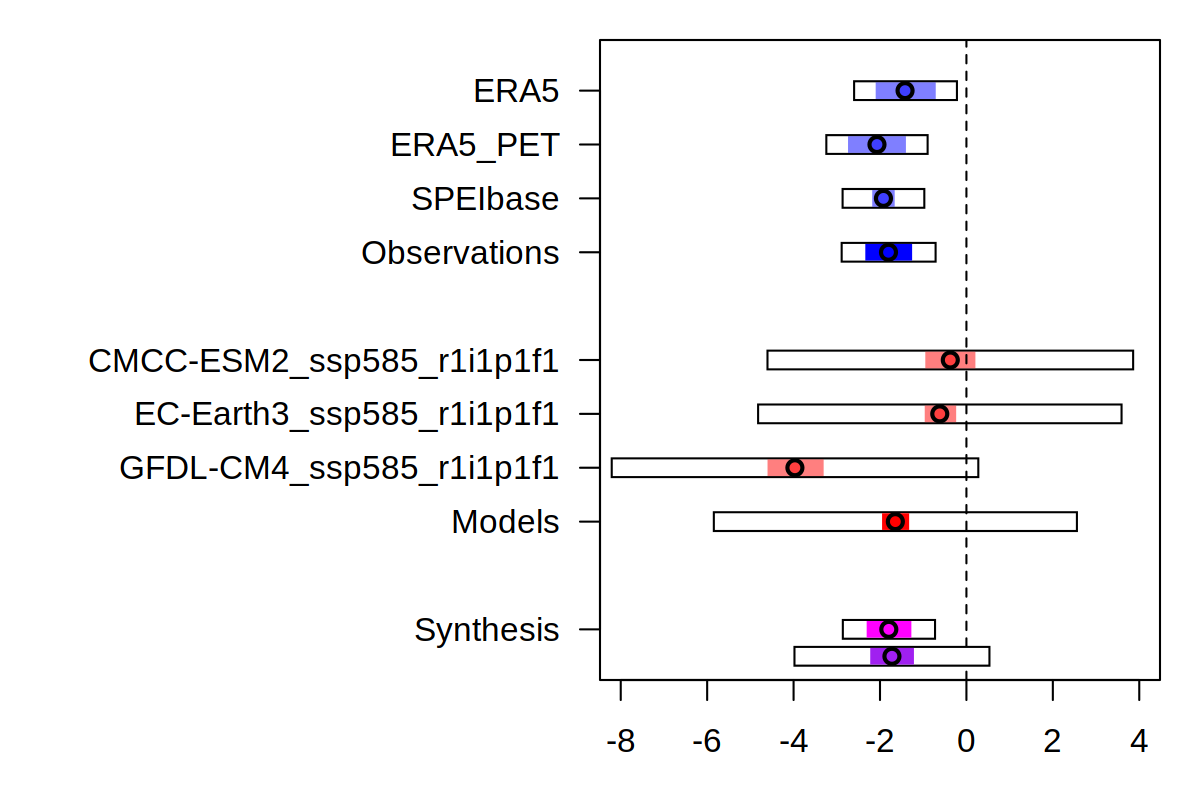

In [17]:
      
mod_synthesis <- function(obs_in, models_in) {

    # Alternative version of synthesis function in which synthesised natural variability and representation error are split out

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get mean of intervals to estimate natural variability component
    obs = apply(obs_in[,c("est", "lower", "upper")], 2, mean)
    
    # compute representation error from scatter of mean
    nobs = nrow(obs_in)
    s2 = sum((obs_in$est - obs[1])^2)
    sig_obs = 2*sqrt(s2/(nobs-1))            # add 2 SDs to either side - representation uncertainty
    
    # apply representation error to synthesis
    obs["l_wb"] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + sig_obs**2 )
    obs["u_wb"] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + sig_obs**2 )

    # add representation error to observations
    obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + sig_obs**2)
    obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + sig_obs**2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get initial estimate of model mean & calculate chi^2
    chi2 <- modsynchi2(models_in, sig_mod = -1)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    # function to be minimized in order to constrain chi^2 to be close to 1
    sigmod <- optim(-1, function(x) {(modsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- modsynmean(models_in, sig_mod = sigmod)
    model_weights <- 1/((models_in$upper - models_in$lower)^2 + (2*sigmod)^2)
    
    # add representation error to observations
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # weighted mean of models & obs (weighted by TOTAL precision - coloured bar)
    w_obs <- unname((obs["u_wb"] - obs["l_wb"])^{-2})
    w_mod <- unname((models["u_wb"] - models["l_wb"])^{-2})
    
    wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    synth <- setNames(c(wmean, 
                        wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod),
                        wmean - sqrt( (w_obs*(obs["est"]-obs["l_wb"]))^2 + (w_mod*(models["est"]-models["l_wb"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["u_wb"]))^2 + (w_mod*(models["est"]-models["u_wb"]))^2 )/(w_obs+w_mod)),
                      c("est", "lower", "upper", "l_wb", "u_wb"))
    
    # unweighted mean of obs and models
    umean <- (obs["est"] +  models["est"]) / 2
    synth_uw <- setNames(c(umean,
                           umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2,
                           umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2,
                           umean - sqrt((obs["est"]-obs["l_wb"])^2 + (models["est"]-models["l_wb"])^2)/2,
                           umean + sqrt((obs["est"]-obs["u_wb"])^2 + (models["est"]-models["u_wb"])^2)/2),
                         c("est", "lower", "upper", "l_wb", "u_wb"))

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    obs_in <- cbind(obs_in, "group" = "obs")
    obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
    models_in <- cbind(models_in, "group" = "models")
    models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
    synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

    res <- plyr::rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
    for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

    return(list(sig_rep = sig_obs, "chi2dof" = chi2 / mdof, df = res, synth_uw = synth_uw, w_j = model_weights))
}

# load data and split into obs & models
df_in = read.csv("minisynth_in.txt", comment.char = "#", header = F, sep = " ")
colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
obs_in = df_in[df_in$m2 == "",]
models_in = df_in[df_in$m2 != "",]
                 
synth2 <- mod_synthesis(obs_in, models_in)
par(mar = c(3,15,1,1))
plot_synthesis(synth2, lwd = 10)       

lwd <- 10
lines(synth2$synth_uw[c("l_wb", "u_wb")], rep(-0.5,2), lwd = lwd, col = "black", lend = 2)
lines(synth2$synth_uw[c("l_wb", "u_wb")], rep(-0.5,2), lwd = lwd-2, col = "white", lend = 2)
lines(synth2$synth_uw[c("lower", "upper")], rep(-0.5,2), lwd = lwd-2, col = "purple", lend = 2)
points(synth2$synth_uw["est"], -0.5, pch = 21, bg = "purple", lwd = 2, cex = lwd/10)

---
# Effect of truncated infinite values

In [83]:
modplot_synthesis <- function(synth, xlim, lwd = 7, vline = 0, xlab = "", main = "") {

    if (class(synth) == "list") synth <- synth$df
    if (missing(xlim)) xlim <- range(pretty(as.numeric(unlist(synth[,c("l_wb", "u_wb")]))))

    nobs <- sum(synth$group == "obs")
    nmod <- sum(synth$group == "models")

    yy <- 1:nrow(synth)
    
    plot(0, type = "n", xlim = xlim, ylim = c(-0.5,nrow(synth)+1.5),
         yaxt = "n", ylab = "", xlab = xlab, main = main)

    gcols = c("obs" = adjustcolor("blue", 0.5),
              "obs_synth" = "blue",
              "models" = adjustcolor("red", 0.5),
              "model_synth" = "red",
              "synth" = "magenta")[synth$group]
    
    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd, col = "black", lend = 2)
    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd-2, col = "white", lend = 2)
    segments(y0 = yy, x0 = synth$lower, x1 = synth$upper, lwd = lwd-2, col = gcols, lend = 1)
    points(synth$est, yy, pch = 21, bg = gcols, lwd = 2, cex = lwd/10)
    
    axis(2, at = yy, labels = synth$model, las = 1)    
    abline(v = vline, lty = 2)
}

### Truncated obs

In [154]:
obs_pr <- data.frame("model" = paste0("obs_", 1:nrow(obs_adj)), "est" = 1:3, "lower" = (2:4)/10, upper = c(100,150,200))
model_pr <- data.frame("model" = paste0("model_", 1:nrow(obs_adj)), "est" = 1:3, "lower" = (2:4)/10, upper = c(100,150,200))

lwd = 10

# pdf("infinite_obs.pdf", height = 7*.5, width = 7*2); par(cex.main = 1.4); {
    par(mfrow = c(1,2))


    for (v in c(10,100)) {
        obs_adj[1,"upper"] <- v
        synth2 <- wwa_synthesis(obs_pr, model_pr)$df
        
        # adjust df to show only the relevant elements (hide models & merge weighted & unweighted synthesis)
        synth2 <- synth2[synth2$group != "models",]
        # synth2$df[synth2$df$group == "synth", c("l_wb", "u_wb")] <- synth2$synth_uw[c("l_wb", "u_wb")]
        # synth2$df[synth2$df$model == "Observations", c("l_wb", "u_wb")] <- synth2$df[synth2$df$model == "Observations", c("lower", "upper")]
        # synth2$df[synth2$df$model == "Models", c("l_wb", "u_wb")] <- synth2$df[synth2$df$model == "Models", c("lower", "upper")]

        par(mar = c(3,7,2,1))
        plot_synthesis(synth2, lwd = lwd, xlim = c(0,10), log = "x", add_space = F, main = paste0("Truncated at ",v))    
    }
    
# }; dev.off()

ERROR: Error in plot_synthesis(synth2, lwd = lwd, xlim = c(0, 10), log = "x", : unused argument (log = "x")


In [ ]:
# what if we truncate everything?
obs_adj <- obs_in
obs_adj$model <- paste0("obs_", 1:nrow(obs_adj))
lwd = 10

# pdf("infinite_obs.pdf", height = 7*.5, width = 7*2); par(cex.main = 1.4); {
    par(mfrow = c(1,2))


    for (v in c(10,100)) {
        obs_adj[,"upper"] <- v
        synth2 <- wwa_synthesis(obs_adj, models_in)$df
        
        # adjust df to show only the relevant elements (hide models & merge weighted & unweighted synthesis)
        synth2 <- synth2[synth2$group != "models",]
        par(mar = c(3,7,2,1))
        plot_synthesis(synth2, lwd = lwd, xlim = c(-8,10), add_space = F, main = paste0("Truncated at ",v))    
    }
    
# }; dev.off()

### Truncated models

In [145]:
models_adj <- models_in
models_adj$model <- paste0("model_", 1:nrow(models_adj))
lwd = 10

pdf("infinite_model.pdf", height = 7*.5, width = 7*2); par(cex.main = 1.4); {
    par(mfrow = c(1,2))

    for (v in c(3,100)) {
        models_adj[1,"upper"] <- v
        
        synth2 <- wwa_synthesis(obs_in, models_adj)$df
        
        # adjust df to show only the relevant elements (hide observations)
        synth2 <- synth2[synth2$group != "obs",]

        par(mar = c(3,7,2,1))
        plot_synthesis(synth2, lwd = lwd, xlim = c(-8,10), add_space = F, main = paste0("Truncated at ",v))    
    }
}; dev.off()

png 
  2

[1] 9.794318e-05 9.791766e-05 9.123650e-05

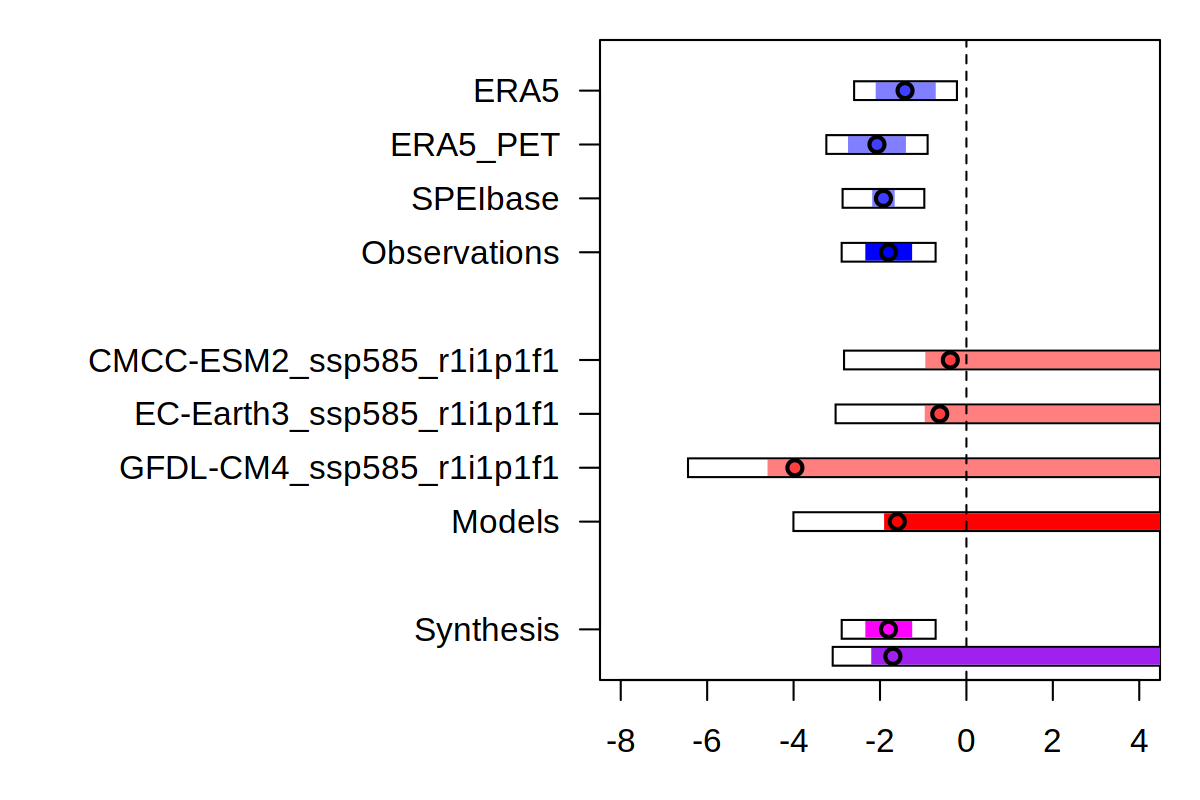

In [144]:
models_adj <- models_in
models_adj[,"upper"] <- 100  # infinite values in all models

synth_infm <- mod_synthesis(obs_in, models_adj)
par(mar = c(3,15,1,1))
plot_synthesis(synth_infm, lwd = 10, xlim = c(-8,4))    
synth_infm$w_j

lines(synth_infm$synth_uw[c("l_wb", "u_wb")], rep(-0.5,2), lwd = lwd, col = "black", lend = 2)
lines(synth_infm$synth_uw[c("l_wb", "u_wb")], rep(-0.5,2), lwd = lwd-2, col = "white", lend = 2)
lines(synth_infm$synth_uw[c("lower", "upper")], rep(-0.5,2), lwd = lwd-2, col = "purple", lend = 2)
points(synth_infm$synth_uw["est"], -0.5, pch = 21, bg = "purple", lwd = 2, cex = lwd/10)

## Weird behaviour when averaging logged obs & models

In [21]:
df_out <- read.fwf("toy_out.txt", comment.char = "#", header = F, widths = c(5,5,12,12,12,12,13,2,99))
df_out <- df_out[!is.na(df_out$V8),]
colnames(df_out) <- c("y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model")

obs_out <- df_out[df_out$group == 1,]
obs_synth <- df_out[df_out$group == 2,]
models_out <- df_out[df_out$group == 3,]
models_synth <- df_out[df_out$group == 4,]
overall_synth <- df_out[df_out$group == 5,]

In [22]:
qsynth <- function(obs, models) {

    obs <- unlist(log(obs[,c("est", "lower", "upper", "l_wb", "u_wb")]))
    models <- unlist(log(models[,c("est", "lower", "upper", "l_wb", "u_wb")]))
   
    w_obs <- unlist(unname((obs["u_wb"] - obs["l_wb"])^{-2}))
    w_mod <- unlist(unname((models["u_wb"] - models["l_wb"])^{-2}))

    print(obs["u_wb"] - obs["l_wb"])
    # print(w_mod)

    wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)

    synth <- setNames(c(wmean, 
                        wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod),
                        wmean - sqrt( (w_obs*(obs["est"]-obs["l_wb"]))^2 + (w_mod*(models["est"]-models["l_wb"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["u_wb"]))^2 + (w_mod*(models["est"]-models["u_wb"]))^2 )/(w_obs+w_mod)),
                      c("est", "lower", "upper", "l_wb", "u_wb"))

    return(exp(synth))
}

qsynth(obs_synth, models_synth)

    u_wb 
2.302585 


est     lower     upper      l_wb      u_wb 
 74.59627  50.16931 107.56224  50.16931 107.56224

In [23]:
models_synth

,y0,y1,est,lower,upper,l_wb,u_wb,group,model
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
5,1900,2020,78.3,52.5,117,52.5,117,4,"""models """


# Checks of underlying assumptions

## Adding in quadrature

The synthesis assumes that we can add in quadrature to obtain an approximate 95% interval: $q^{(u)} = \sqrt{\left(q_1^{(u)} - \mu_1\right)^2 + 4\sigma_2^2}$. How realistic is this?

- Seems to give a very close approximation generally and to be almost exact when when s1 > s2: that is, when the variance of the amount added is smaller than the variance of the amount arising from the confidence bounds.


In [78]:
qadd <- function(s1, s2) {

    s <- sqrt(s1^2 + s2^2)
    q_v <- qnorm(0.975, sd = s)
    q_sum <- sqrt(qnorm(0.975, sd = s1)^2 + (2*s2)^2)
    return(c(q_v, q_sum))
}

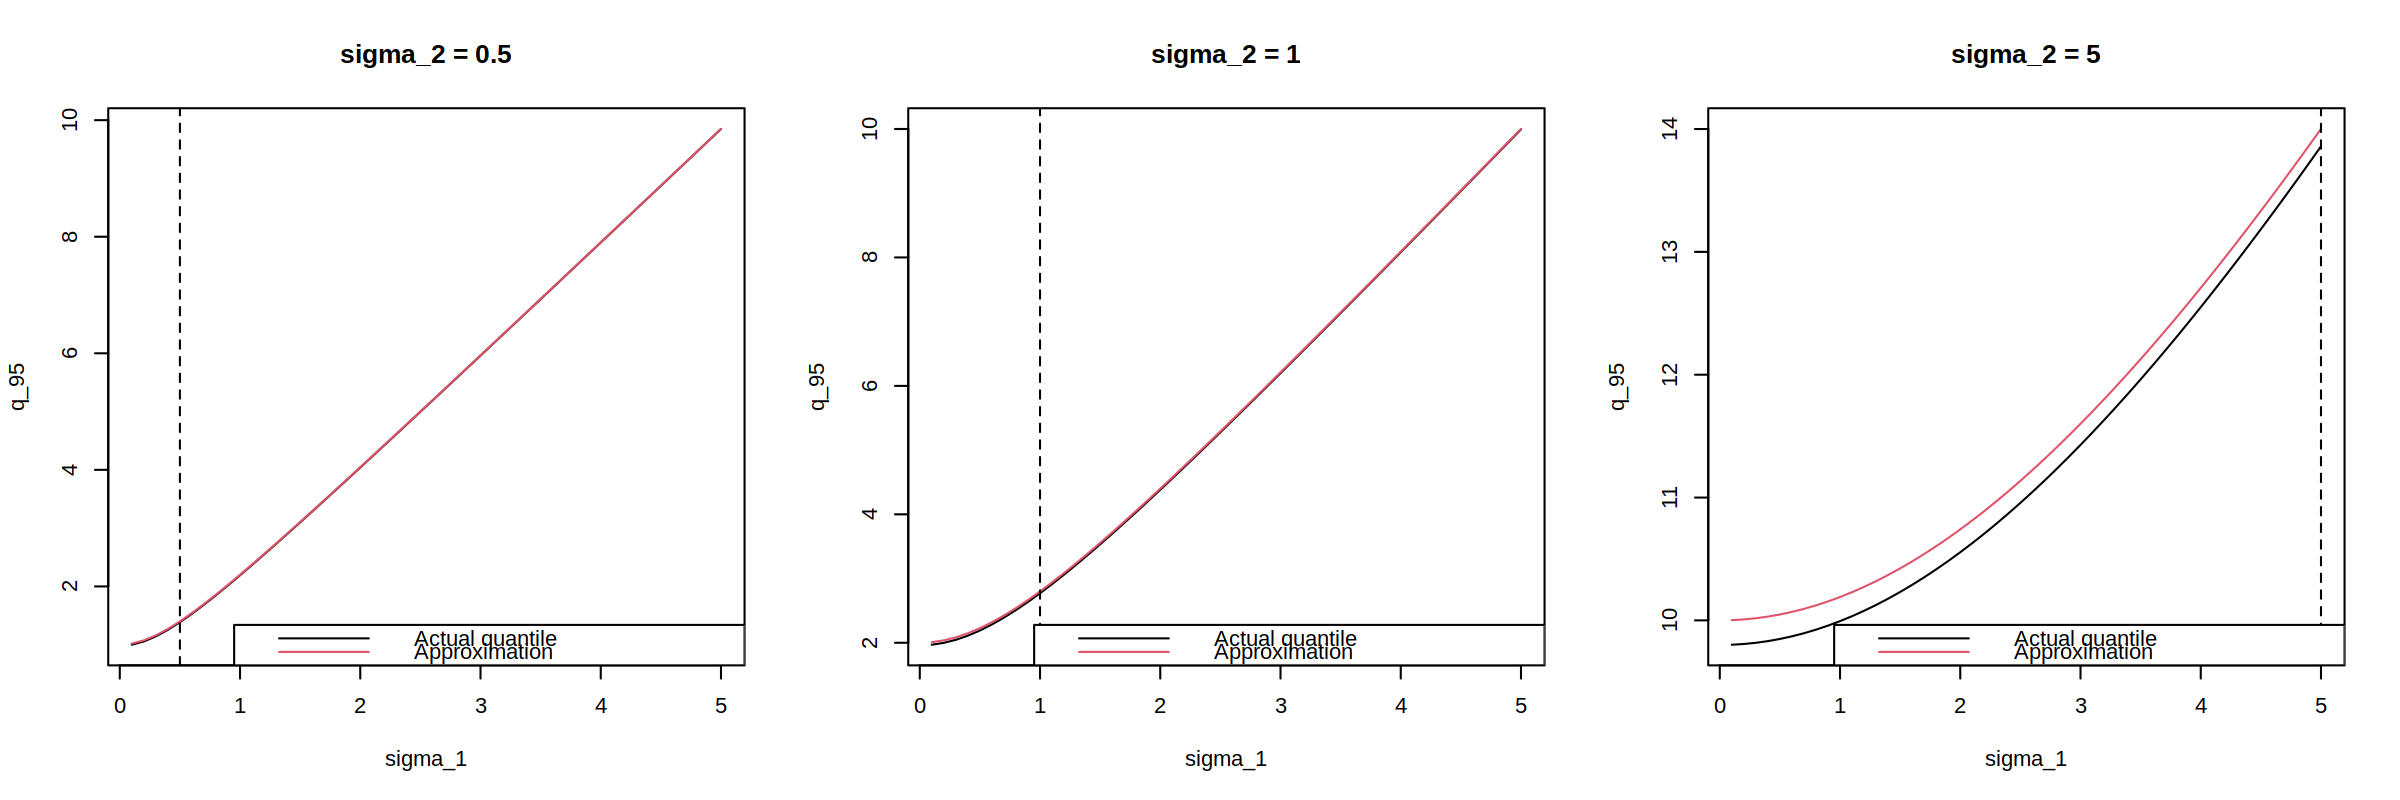

In [135]:
prep_window(c(1,3))
x <- seq(0.1,5,0.1)
for(s2 in c(0.5,1,5)) {
    matplot(x, t(sapply(x, qadd, s2)), type = "l", lty = 1, xlab = "sigma_1", ylab = "q_95", main = paste0("sigma_2 = ",s2))
    abline(v = s2, lty = 2)
    legend("bottomright", c("Actual quantile", "Approximation"), col = 1:2, lty = 1)
}

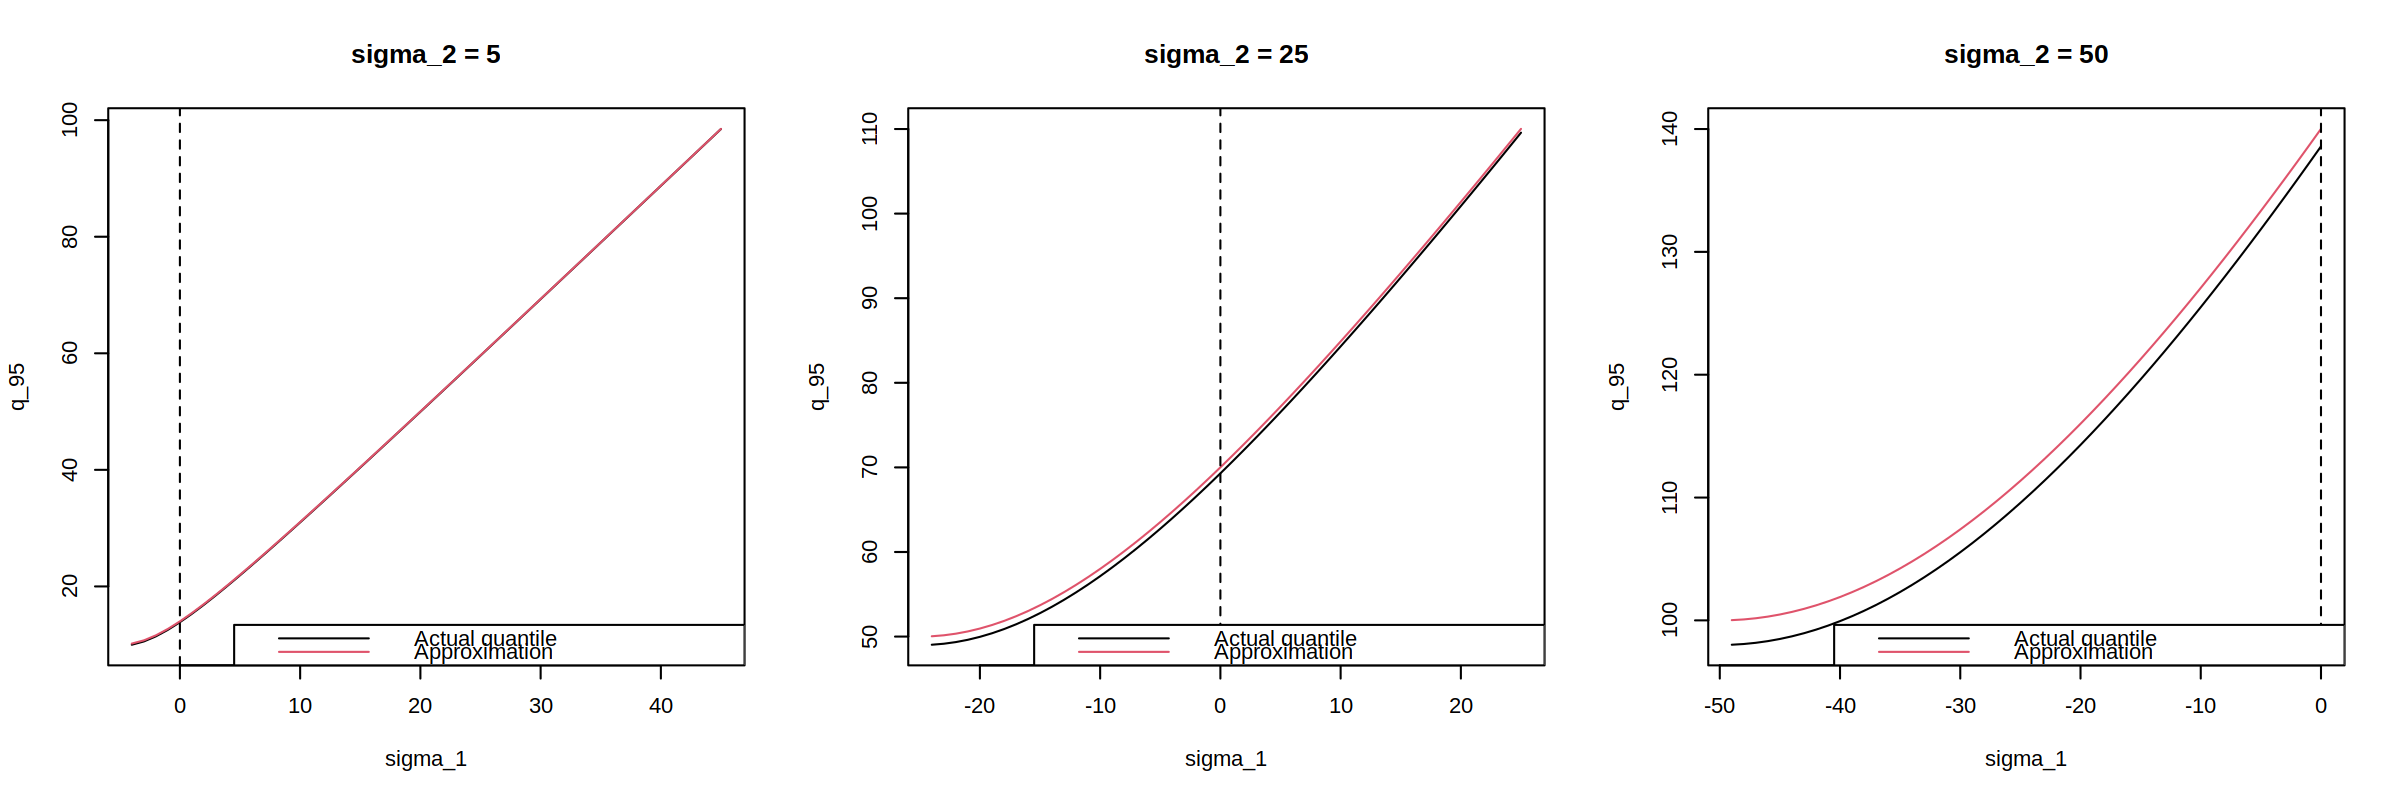

In [136]:
prep_window(c(1,3))
x <- seq(1,50,1)
for(s2 in c(5,25,50)) {
    matplot(x-s2, t(sapply(x, qadd, s2)), type = "l", lty = 1, xlab = "sigma_1", ylab = "q_95", main = paste0("sigma_2 = ",s2))
    abline(v = 0, lty = 2)
    legend("bottomright", c("Actual quantile", "Approximation"), col = 1:2, lty = 1)
}

## Model weights
In the synthesis paper, I've stated that the weights are the inverse square of the total variance for each model, so that $w_j = \left(\sigma_j^2 + \sigma_{mrep}^2\right)^{-1}$.  
However, this is actually implemented using confidence intervals rather than variances - what difference (if any) might this make?

- This has now been corrected in the manuscript - actually these two methods would produce quite different weightings, so the two are not directly interchangeable
- Weighting by confidence intervals puts less weight on the most confident models than weighting by variances, so the range of model weights is narrower

In [28]:
weights <- function(sigma) {
    w_sig <- 1/sigma^2
    w_qq <- 1/diff(qnorm(c(0.025, 0.975), sd = sigma))^2

    # alternative approach in which the bounds are used to estimate the SD, and hence the weights
    w_alt <- 1/((diff(qnorm(c(0.025, 0.975), sd = sigma)) / (2*1.96))^2)
    w_alt <- 1/(4*sigma)^2
    return(c("w_sig" = w_sig, "w_cx" = w_qq, "w_alt" = w_alt))
    }

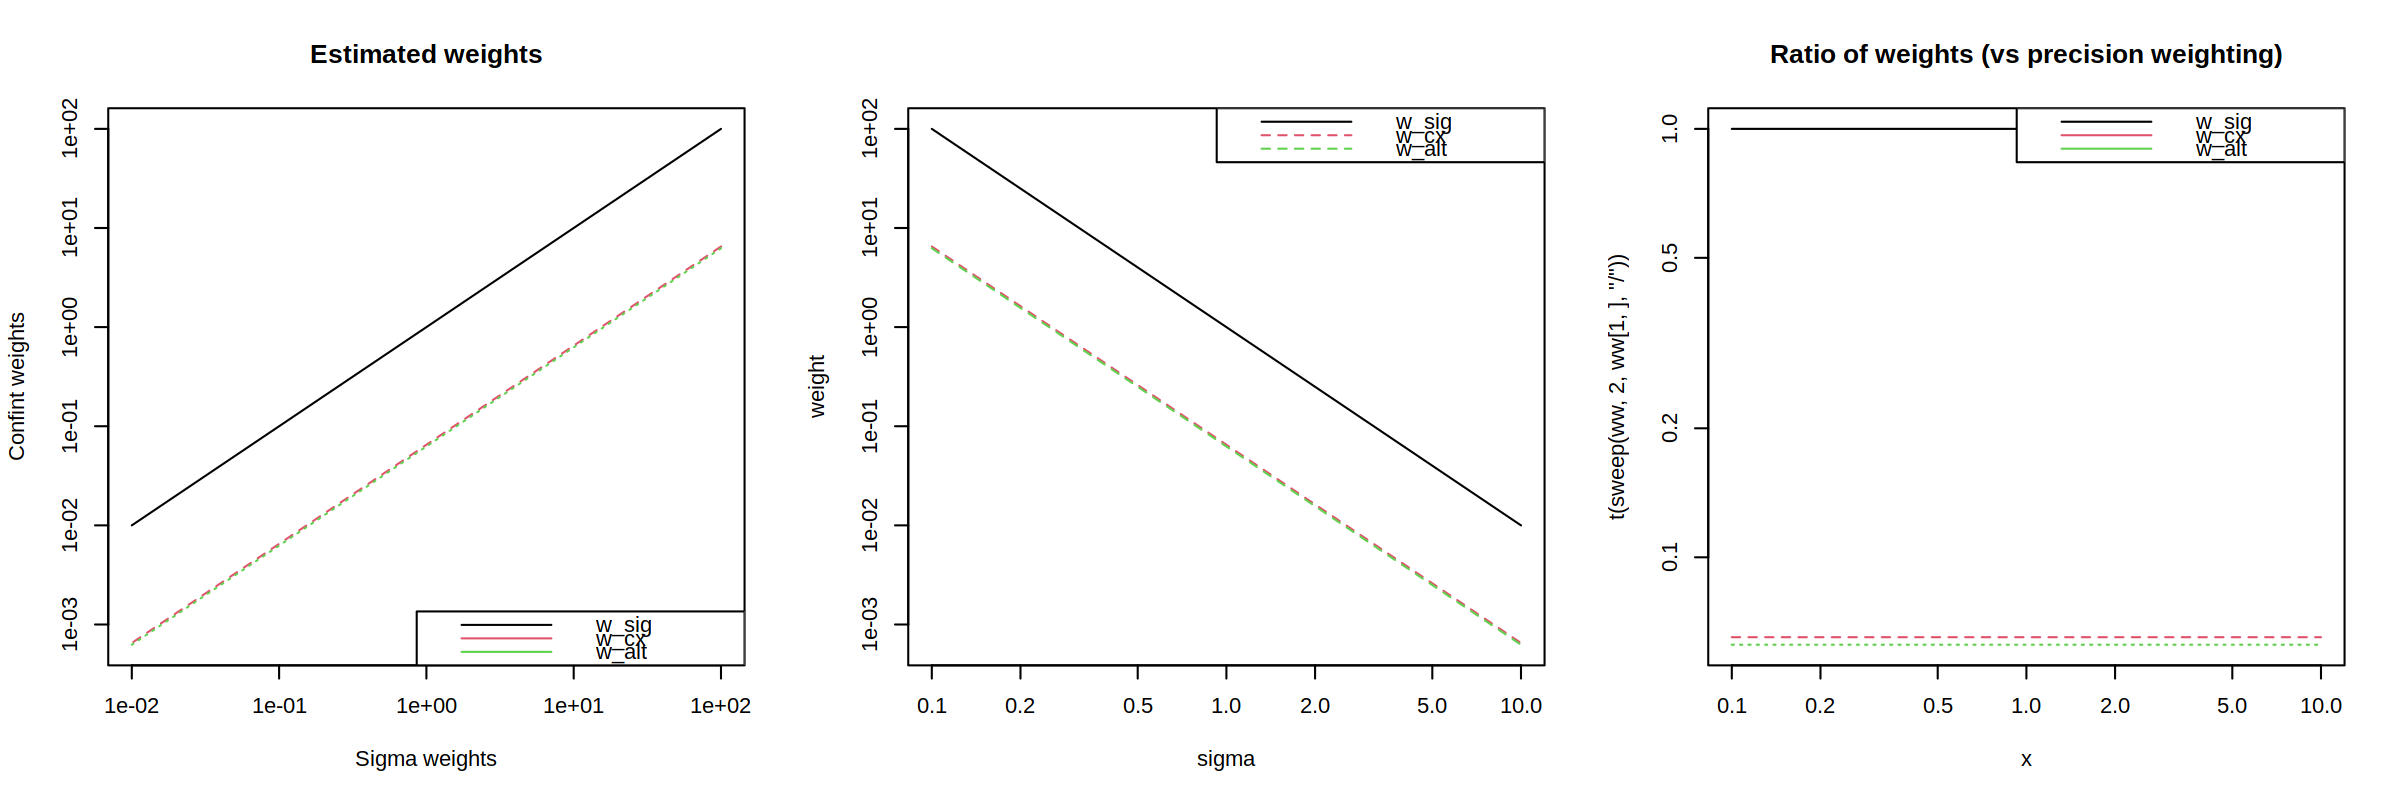

In [31]:
prep_window(c(1,3))

x <- seq(0.1,10,0.01)

ww <- sapply(x, weights)

matplot(ww[1,], t(ww), type = "l", log = "xy", main = "Estimated weights", xlab = "Sigma weights", ylab = "Confint weights")
legend("bottomright", legend = c(rownames(ww)), lty = 1, col = 1:nrow(ww))

matplot(x, t(ww), type = "l", log = "xy", xlab = "sigma", ylab = "weight", lty = c(1, rep(2, nrow(ww))))
legend("topright", legend = rownames(ww), col = 1:nrow(ww), lty = c(1, rep(2, nrow(ww))))

matplot(x, t(sweep(ww, 2, ww[1,], "/")), type = "l", log = "xy", main = "Ratio of weights (vs precision weighting)")
legend("topright", legend = rownames(ww), lty = 1, col = 1:nrow(ww))

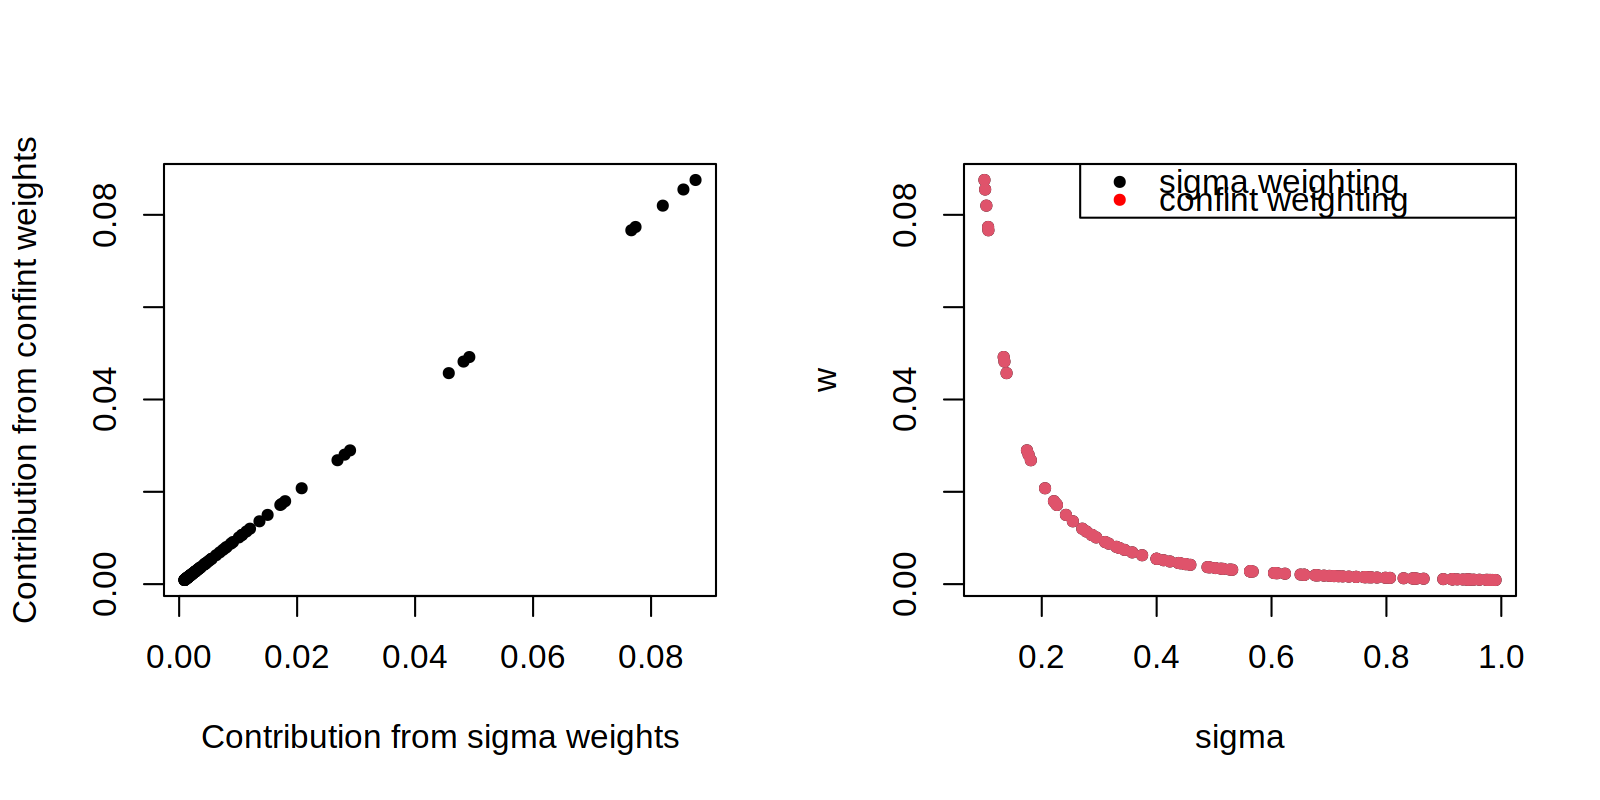

In [30]:
# what does this do to the relative contributions when we have multiple models?

set.seed(42)
sigma <- runif(100,0.1,1)
w <- sapply(sigma, weights)[1:2,]
w <- t(w / rowSums(w))

prep_window(c(1,2))
plot(w, xlab = "Contribution from sigma weights", ylab = "Contribution from confint weights")

matplot(sigma, w, pch = 20, log = "")
legend("topright", legend = c("sigma weighting", "confint weighting"), pch = 20, col = c("black", "red"))

# using confidence intervals, rather than variances, to compute the weights gives less weight to the most confident models and more to the least confident.

### Related: does weighted mean of intervals give same result as intervals from weighted mean of distributions?
- By averaging intervals rather than variances, we're actually underestimating the uncertainty

In [ ]:
wmean <- function(w = c(0.5,0.5), s1 = 1, s2 = 1) {

    # weights must be normalised to sum to 1 first - otherwise we get odd variances
    w <- w / sum(w)
    wmean_dist <- (qnorm(0.975, sd = sqrt(w[1]*s1^2 + w[2]*s2^2)))
    wmean_int <- (w[1]*qnorm(0.975, sd = s1) + w[2]*qnorm(0.975,sd = s2))

    return(c("dist" = wmean_dist, "int" = wmean_int, "ratio" = wmean_dist / wmean_int))
}

In [ ]:
wmean(w = c(1,3), s1 = 1, s2 = 4)
wmean(w = c(1,3), s1 = 4, s2 = 1)

dist      int    ratio 
6.859874 6.369883 1.076923

dist      int    ratio 
4.271642 3.429937 1.245400

## $\chi^2$ using variances vs using confidence bounds

Ideally, we would compute $\chi^2$ as $\sum_j \frac{\left(\mu_j - \mu_{mod}\right)^2}{\sigma_j^2 + \sigma_{mrep}^2}$.  
However, in practice we don't have $\sigma_j$, so instead we have to use the confidence bounds in the denominator, so that $\sigma_j^2$ is replaced with $\left(\mu_j - q_j^{(l)}\right)^2$ or $\left(\mu_j - q_j^{(u)}\right)^2$, depending on whether $\mu_j$ is less than or greater than $\mu_{mod}$.

- actually, this is a very close approximation as long as there's no representation error (see 'adding in quadrature' above)
- however, if the representation error is more than double $\sigma_j$, the approximation is poor
- this is fixed by multiplying $\sigma_{mrep}$ by 2 to ensure that the denominator is expressed entirely in terms of 95% intervals

In [93]:
chi2 <- function(sig_j, mu_j = 1, sig_rep = 0) {
    # assuming that mu_obs = 0
    chi_sig <- mu_j^2 / (sig_j^2 + sig_rep^2)
    chi_confint <- mu_j^2 / ((qnorm(0.975, mu_j, sig_j) - mu_j)^2 + sig_rep^2)

    chi_corrected <- mu_j^2 / ((qnorm(0.975, mu_j, sig_j) - mu_j)^2 + (2*sig_rep)^2)
    chi_alt <- mu_j^2 / (((qnorm(0.975, mu_j, sig_j) - mu_j)/2)^2 + (sig_rep)^2)

    chi_196 <- mu_j^2 / (((qnorm(0.975, mu_j, sig_j) - mu_j)/1.96)^2 + (sig_rep)^2)

    return(c("chi_sig" = chi_sig, "chi_confint" = 4 * chi_confint, "chi_corrected" = 4*chi_corrected, "chi_alt" = chi_alt, "chi_196" = chi_196))
}

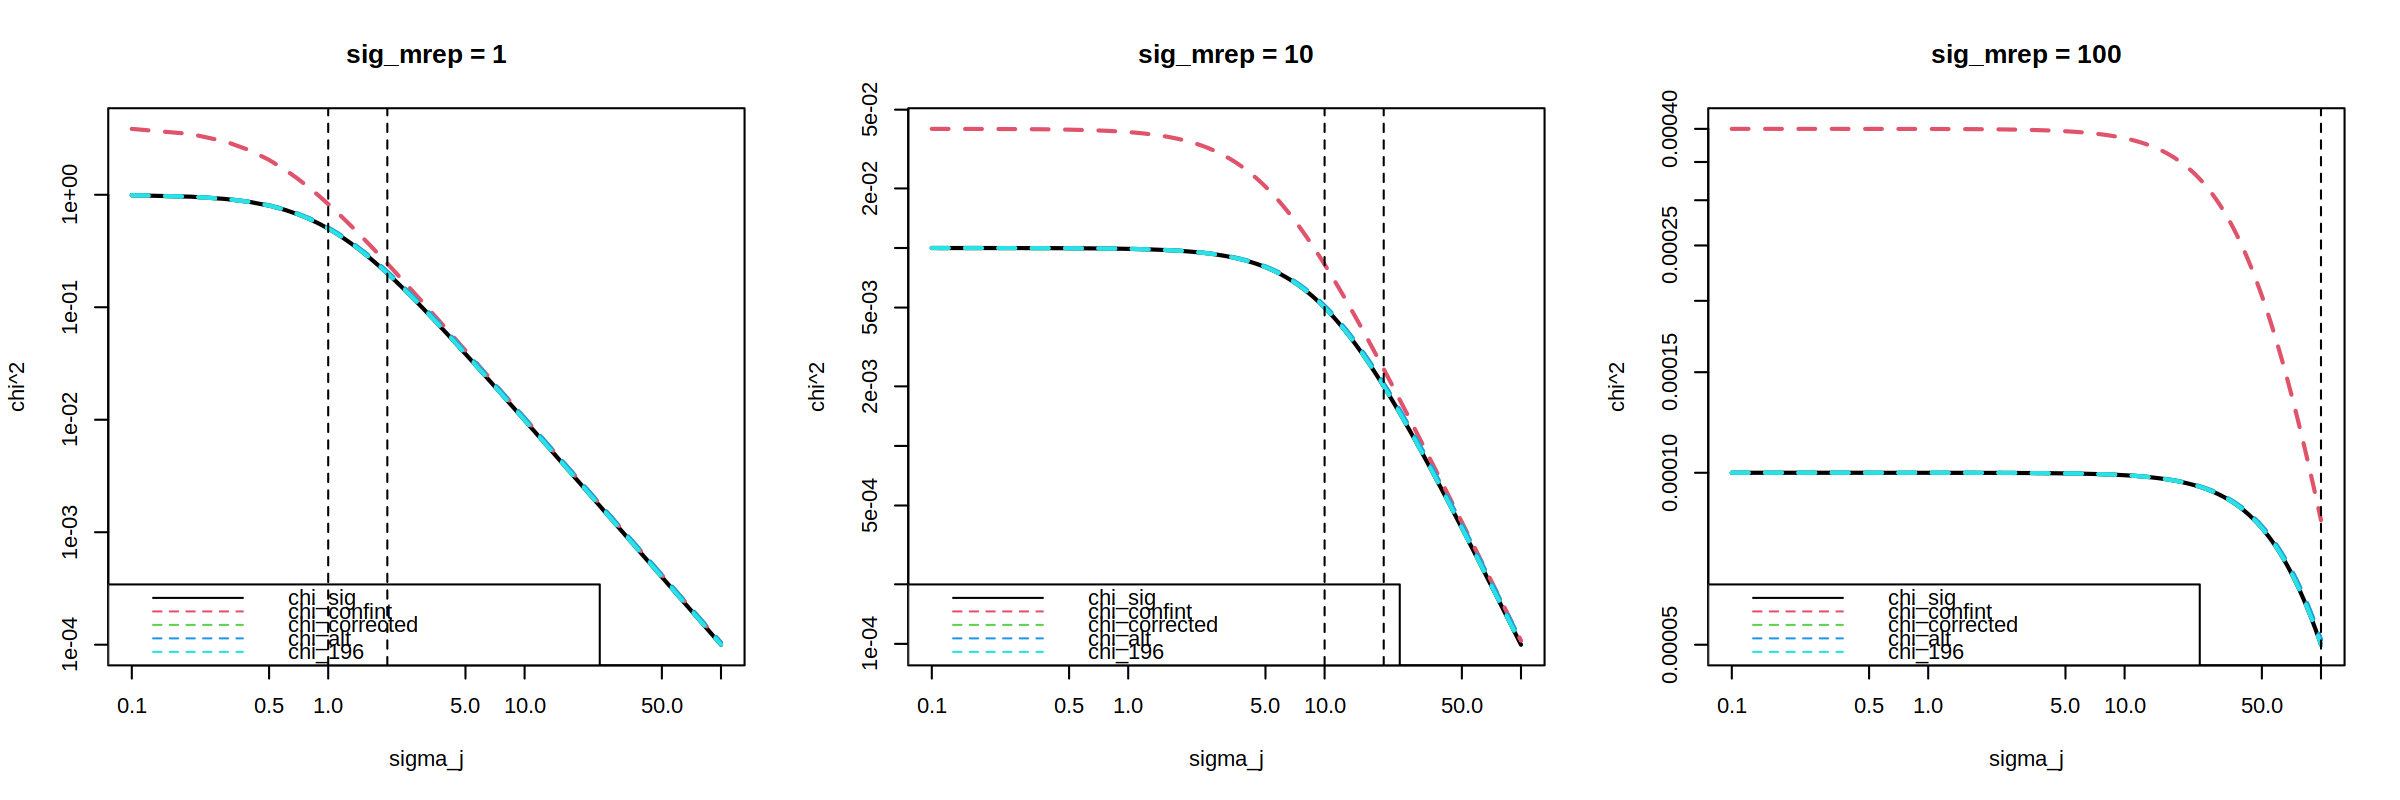

In [194]:
prep_window(c(1,3))

x <- seq(0.1,100,0.1)

for(sig_mrep in c(1,10,100)) {
    chi2_est <- sapply(x, chi2, sig_rep = sig_mrep)
    matplot(x, t(chi2_est), type = "l", log = "xy", lwd = 2, main = paste0("sig_mrep = ", sig_mrep), ylab = "chi^2", xlab = "sigma_j", lty = c(1, rep(2, nrow(chi2_est))))
    legend("bottomleft", rownames(chi2_est), col = 1:nrow(chi2_est), lty = c(1, rep(2, nrow(chi2_est))))
    abline(v = sig_mrep * c(1,2), lty = 2)
}

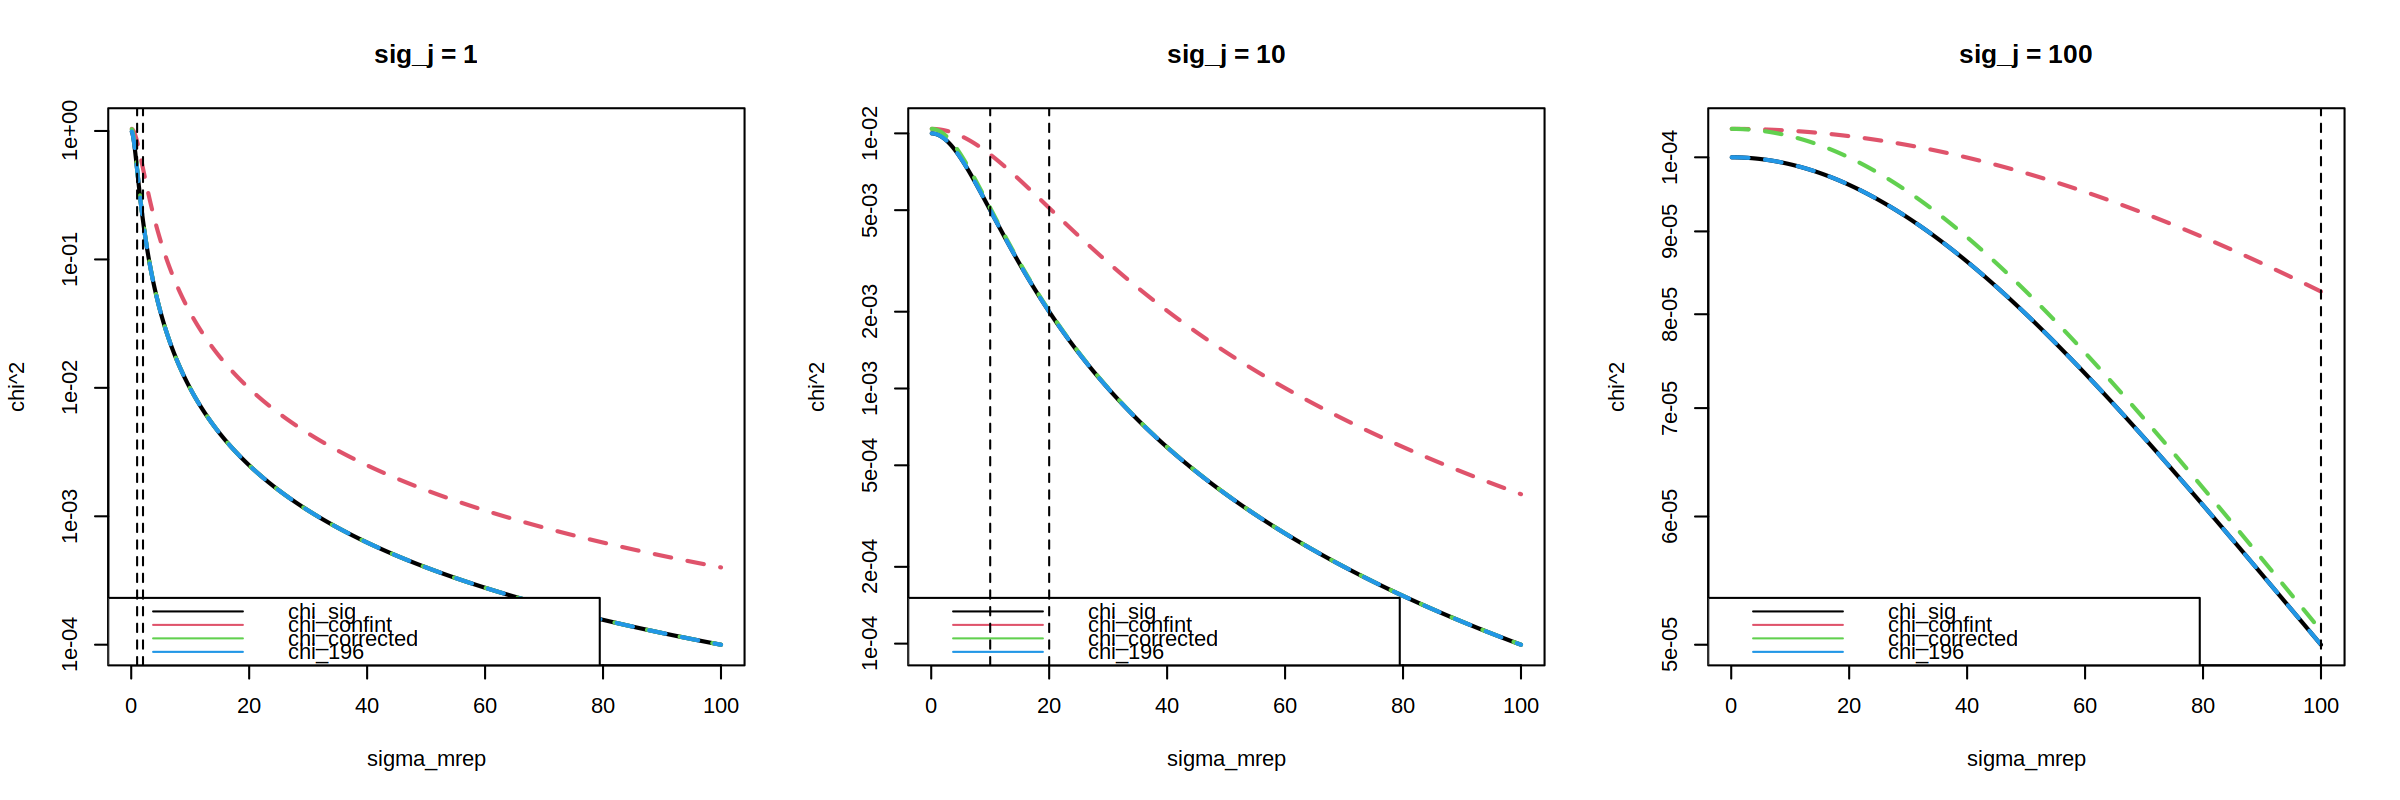

In [221]:
prep_window(c(1,3))

x <- seq(0.1,100,0.1)

for(sig_j in c(1,10,100)) {
    chi2_est <- sapply(x, function(sig_mrep) chi2(sig_j = sig_j, sig_rep = sig_mrep))[c("chi_sig", "chi_confint", "chi_corrected", "chi_196"),]
    matplot(x, t(chi2_est), type = "l", log = "y", lwd = 2, lty = c(1, rep(2, nrow(chi2_est))),  main = paste0("sig_j = ", sig_j), ylab = "chi^2", xlab = "sigma_mrep")
    legend("bottomleft", rownames(chi2_est), lty = 1, col = 1:nrow(chi2_est))
    abline(v = sig_j * c(1,2), lty = 2)
}

### Effect of the current error in the synthesis?
- we only estimate $\sigma_{mrep}$ when $\chi^2 > (n_j-1)$
- $\chi^2_{org} \geq \chi^2_{fixed}$ so we've probably included model error when it wasn't necessary
- for the same value of $\chi^2$, the original method gives a higher value of $\sigma_{mrep}$ than the corrected method: since we find $\sigma_{mrep} = argmin\left(\chi^2(\sigma_{mrep}) - (n_i-1)\right)^2$, that suggests we've consistently over-estimated the model error  
  &nbsp;
- experiments suggest that the model variance is currently over-estimated due to the error (which is good - we've been more conservative)
- dividing the bounds by 2 usually gives an accurate approximation to the true value, and should over-estimate the model error for individual runs: however, experiments (below) suggest that it may also under-estimate it in more realistic settings

In [211]:
getsynchi2_org <- function(data, sig_mod = 0) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, )["est"]

    # again, we're adding to bounds so should be adding (2sig_adj)^2 here - or is it handled below?
    
    # compute chi2 based on model intervals & sigma adjustment - this is a ratio of variances
    # actually I'm not sure if this shouldn't be the upper sum divided by the lower sum...
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_mod^2)
        } else {
            (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_mod^2)
        }
    }))

    # think this is supposed to give the same results as adding (2sig_adj)^2, but it won't
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}

getsynchi2_fixed <- function(data, sig_mod = 0) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, sig_mod)["est"]

    # again, we're adding to bounds so should be adding (2sig_adj)^2 here - or is it handled below?
    
    # compute chi2 based on model intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / (((x["est"] - x["lower"])/2)^2 + sig_mod^2)
        } else {
            (x["est"] - s1)^2 / (((x["est"] - x["upper"])/2)^2 + sig_mod^2)
        }
    }))

    # think this is supposed to give the same results as adding (2sig_adj)^2, but it won't
    # chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}

In [207]:
df_in = read.csv("toy_in.txt", comment.char = "#", header = F, sep = " ")
colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
obs_in = df_in[(df_in$m2 == "") & (!is.na(df_in$est)),]
models_in = df_in[df_in$m2 != "",]

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on 'toy_in.txt'”


In [226]:
sigmod_org <- optim(0, function(x) {(getsynchi2_org(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
# sigmod_fixed <- optim(0, function(x) {(getsynchi2_fixed(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
sigmod_fixed2 <- optim(0, function(x) {(getsynchi2_fixed(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par

In [209]:
sigmod_org

[1] 6.403797e-07

In [213]:
sigmod_fixed

[1] 2.727583e-07

In [216]:
sigmod_fixed / sigmod_fixed2 / nrow(models_in)

[1] 0.6820855

In [220]:
(2*1.96)^2

[1] 15.3664